In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [54]:
# Загрузка данных
try:
    data_path = 'datasets/train.json'
    df = pd.read_json(data_path)
    print("Данные успешно загружены")
except FileNotFoundError:
    print("Ошибка: файл 'train.json' не найден в папке 'datasets'.")
    exit()
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")
    exit()

Данные успешно загружены


In [55]:
# Размер данных
print(f"Размер данных (строк, столбцов): {df.shape}")

Размер данных (строк, столбцов): (49352, 15)


In [56]:
# Список столбцов и целевой столбец
print("Список столбцов:")
print(df.columns.tolist())
print("\nЦелевой столбец: interest_level")

Список столбцов:
['bathrooms', 'bedrooms', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'price', 'street_address', 'interest_level']

Целевой столбец: interest_level


In [57]:
# Быстрый анализ данных

print("Информация о DataFrame:")
df.info()

print("\nСтатистическое описание DataFrame:")
print(df.describe())

# Выбираем только числовые столбцы для вычисления корреляции
df_numeric = df.select_dtypes(include='number')

print("\nКорреляционная матрица (только для числовых столбцов):")
print(df_numeric.corr())

Информация о DataFrame:


<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB

Статистическое описание DataFrame:
         bathro

In [58]:
# Создание DataFrame с нужными столбцами
df_selected = df[['bathrooms', 'bedrooms', 'interest_level', 'price']]
print("DataFrame с выбранными столбцами:")
print(df_selected.head())

DataFrame с выбранными столбцами:
    bathrooms  bedrooms interest_level  price
4         1.0         1         medium   2400
6         1.0         2            low   3800
9         1.0         2         medium   3495
10        1.5         3         medium   3000
15        1.0         0            low   2795


### Анализ цели

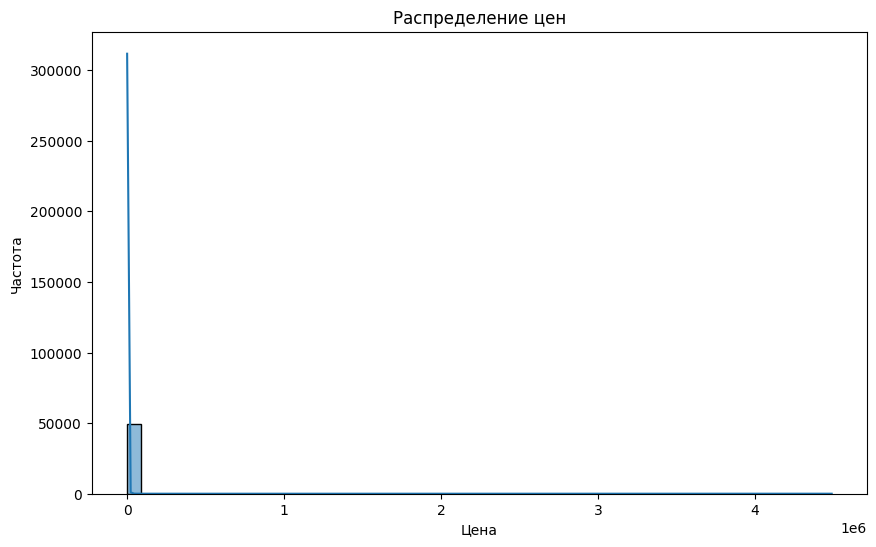

In [59]:
# Гистограмма распределения целевой переменной 'price'
plt.figure(figsize=(10, 6))
sns.histplot(df_selected['price'], bins=50, kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

Большая часть значений сосредоточена в одном столбце в районе цены 0 и частоты около 5000. Это происходит из-за того, что в данных присутствуют очень большие выбросы, которые "сжимают" остальное распределение.

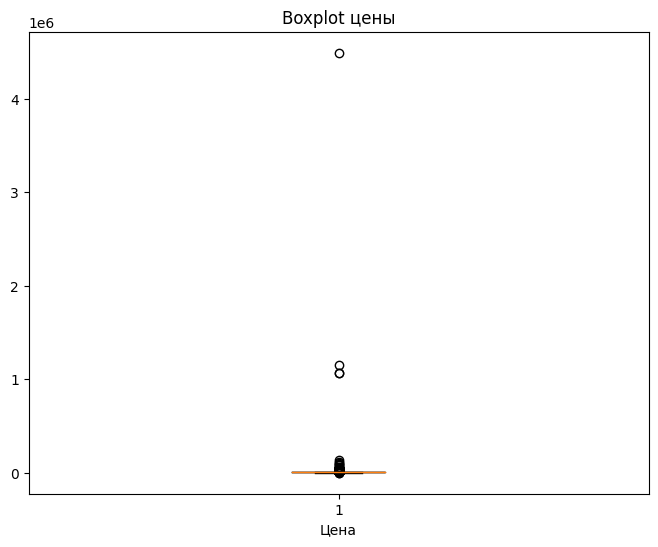

In [60]:
# Boxplot для целевой переменной 'price'
plt.figure(figsize=(8, 6))
plt.boxplot(x=df_selected['price'])
plt.title('Boxplot цены')
plt.xlabel('Цена')
plt.show()

Boxplot показывает, что основная часть данных сгруппирована внизу, а также имеются выбросы в верхней части распределения, что подтверждает необходимость их обработки.

In [61]:
# Удаление выбросов по цене
price_1st_percentile = df_selected['price'].quantile(0.01)
price_99th_percentile = df_selected['price'].quantile(0.99)

# Создание копии DataFrame
df_filtered = df_selected[(df_selected['price'] >= price_1st_percentile) & (df_selected['price'] <= price_99th_percentile)].copy() 
print(f"Размер данных после удаления выбросов по цене: {df_filtered.shape}")

Размер данных после удаления выбросов по цене: (48379, 4)


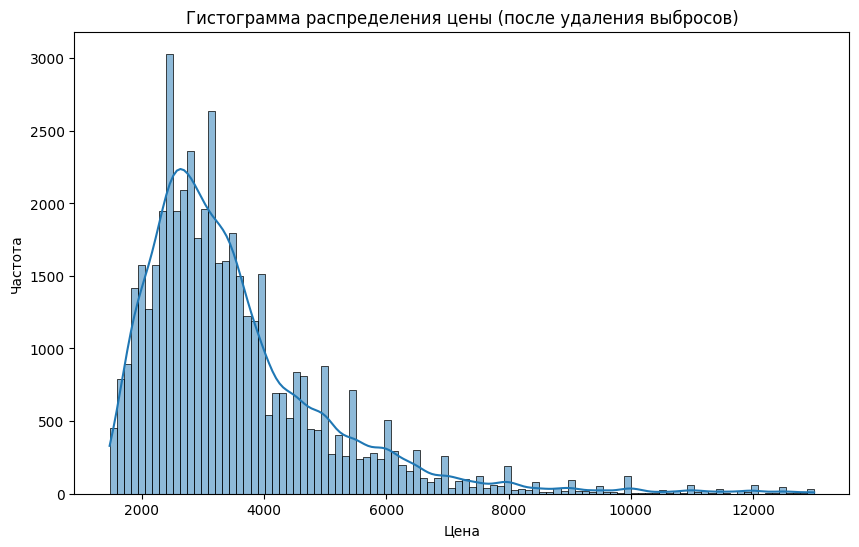

In [62]:
# Гистограмма распределения цены после удаления выбросов
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['price'], bins=100, kde=True)
plt.title('Гистограмма распределения цены (после удаления выбросов)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

### Анализ характеристик

In [63]:
# Тип столбца 'interest_level'
print(f"Тип столбца 'interest_level': {df_filtered['interest_level'].dtype}")

Тип столбца 'interest_level': object


In [64]:
# Значения и количество в столбце 'interest_level'
print("Значения и количество в столбце 'interest_level':")
print(df_filtered['interest_level'].value_counts())

Значения и количество в столбце 'interest_level':
interest_level
low       33697
medium    11116
high       3566
Name: count, dtype: int64


In [65]:
# Расшифровка значений 'interest_level' (замена на числовые)
# Создаем словарь для замены
interest_mapping = {'low': 0, 'medium': 1, 'high': 2}

# Применяем замену к столбцу
df_filtered['interest_level'] = df_filtered['interest_level'].map(interest_mapping)

print("DataFrame после расшифровки 'interest_level':")
print(df_filtered['interest_level'].head())

DataFrame после расшифровки 'interest_level':
4     1
6     0
9     1
10    1
15    0
Name: interest_level, dtype: int64


In [66]:
# Тип столбца 'interest_level'
print(f"Тип столбца 'interest_level': {df_filtered['interest_level'].dtype}")

Тип столбца 'interest_level': int64


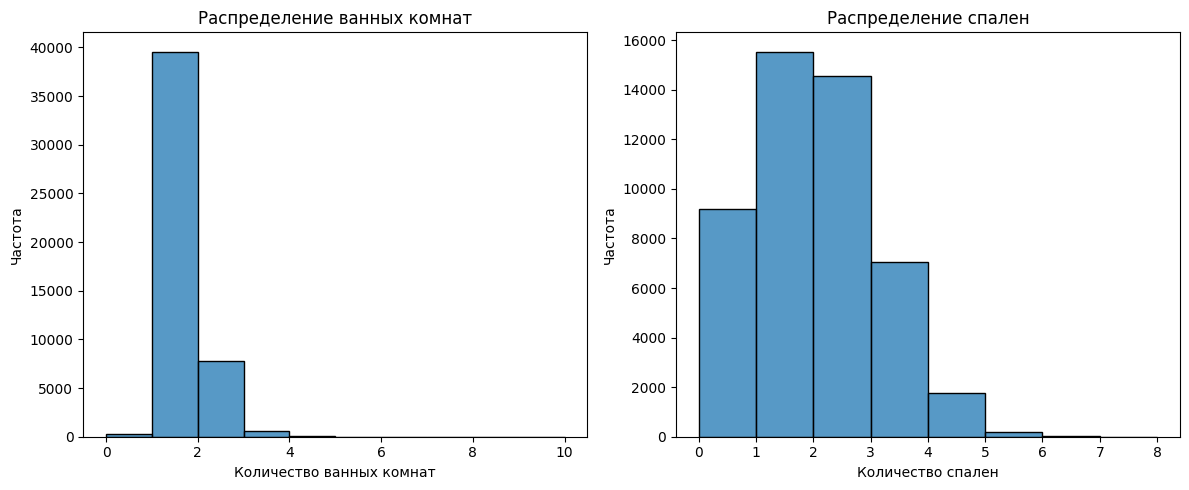

In [67]:
# Гистограммы для признаков 'bathrooms' и 'bedrooms'
plt.figure(figsize=(12, 5))

# 1 строка, 2 столбца, 1-й график
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['bathrooms'], bins=10)
plt.title('Распределение ванных комнат')
plt.xlabel('Количество ванных комнат')
plt.ylabel('Частота')

# 1 строка, 2 столбца, 2-й график
plt.subplot(1, 2, 2)
sns.histplot(df_filtered['bedrooms'], bins=8)
plt.title('Распределение спален')
plt.xlabel('Количество спален')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

### Комплексный анализ

In [68]:
# Матрица корреляции
print("Матрица корреляции:")

# Выбираем только числовые столбцы для корреляции
df_numeric = df_filtered.select_dtypes(include=np.number)
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

Матрица корреляции:
                bathrooms  bedrooms  interest_level     price
bathrooms        1.000000  0.517574       -0.063635  0.671943
bedrooms         0.517574  1.000000        0.050654  0.545948
interest_level  -0.063635  0.050654        1.000000 -0.200111
price            0.671943  0.545948       -0.200111  1.000000


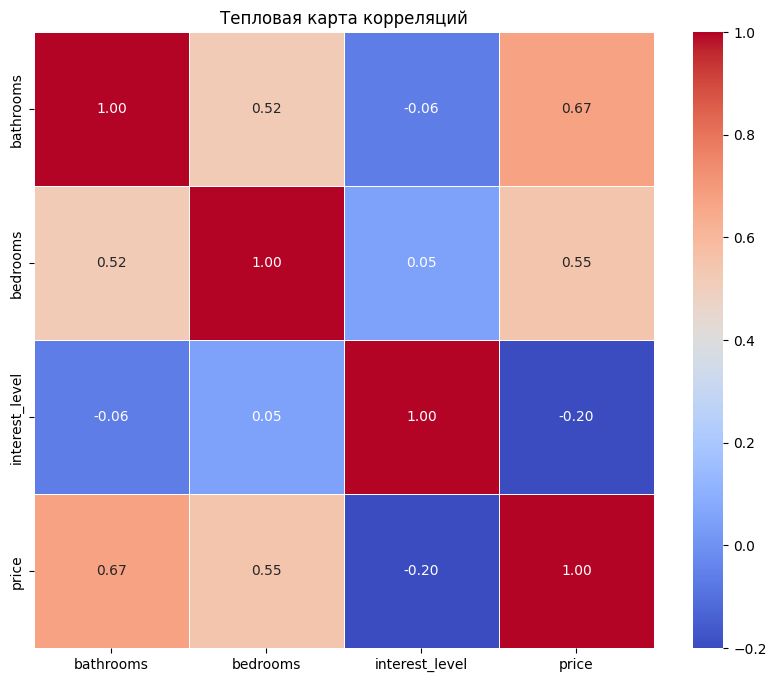

In [69]:
# Тепловая карта матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Тепловая карта корреляций')
plt.show()

Матрица корреляции показывает наличие корреляций между ценой (price) и количеством ванных комнат (bathrooms), а также между ценой и количеством спален (bedrooms). Оба коэффициента корреляции указывают на положительную умеренную корреляцию: по мере увеличения количества ванных комнат и спален, цена также растет. Корреляция между уровнем интереса (interest_level) и ценой (-0.20) является слабой отрицательной: при более высоком уровне интереса цена незначительно снижается.

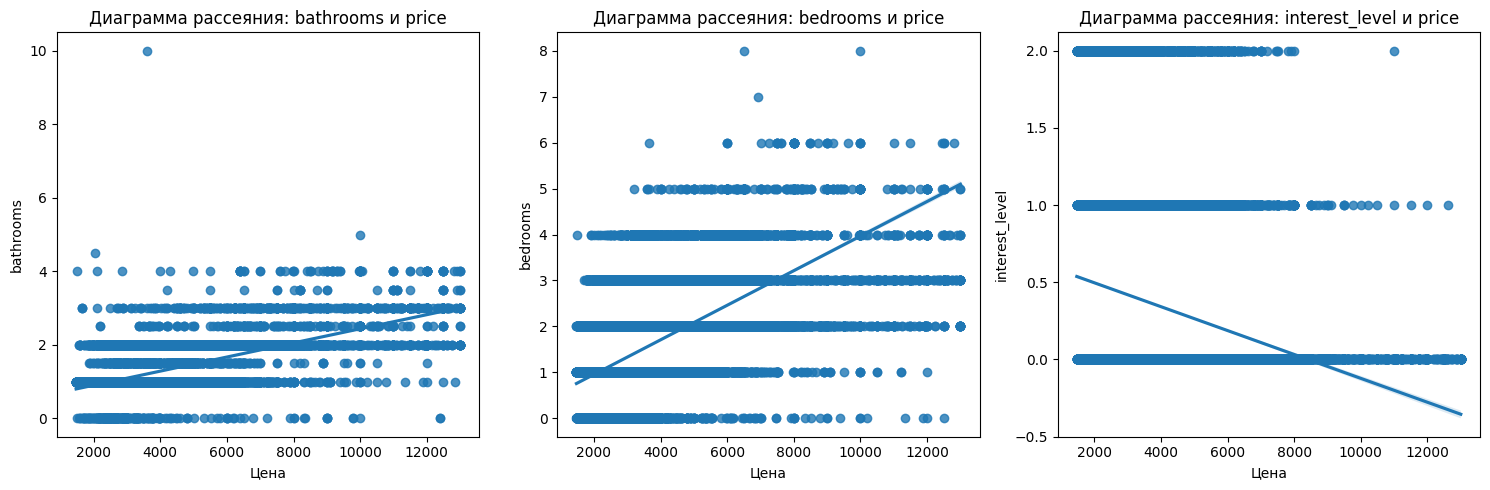

In [70]:
# Диаграммы рассеяния
features = ['bathrooms', 'bedrooms', 'interest_level']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.regplot(x=df_filtered['price'], y=df_filtered[feature])
    plt.title(f'Диаграмма рассеяния: {feature} и price')
    plt.xlabel('Цена')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# Создание функций

In [71]:
# Создание новых признаков
df_filtered['bathrooms_squared'] = df_filtered['bathrooms']**2
df_filtered['bedrooms_squared'] = df_filtered['bedrooms']**2
df_filtered['interest_level_squared'] = df_filtered['interest_level']**2

In [72]:
# Матрица корреляции с новыми признаками
print("Матрица корреляции с новыми признаками:")
df_numeric_with_new = df_filtered.select_dtypes(include=np.number)
correlation_matrix_with_new = df_numeric_with_new.corr()
print(correlation_matrix_with_new)

Матрица корреляции с новыми признаками:
                        bathrooms  bedrooms  interest_level     price  \
bathrooms                1.000000  0.517574       -0.063635  0.671943   
bedrooms                 0.517574  1.000000        0.050654  0.545948   
interest_level          -0.063635  0.050654        1.000000 -0.200111   
price                    0.671943  0.545948       -0.200111  1.000000   
bathrooms_squared        0.956023  0.478817       -0.068558  0.648486   
bedrooms_squared         0.548760  0.928277        0.046340  0.543406   
interest_level_squared  -0.059410  0.039511        0.944013 -0.182672   

                        bathrooms_squared  bedrooms_squared  \
bathrooms                        0.956023          0.548760   
bedrooms                         0.478817          0.928277   
interest_level                  -0.068558          0.046340   
price                            0.648486          0.543406   
bathrooms_squared                1.000000          0.522227 

In [73]:
# Оценка корреляции новых признаков с целевой переменной
print("Корреляция новых признаков с price:")
print(correlation_matrix_with_new['price'].loc[['bathrooms_squared', 'bedrooms_squared', 'interest_level_squared']])
print("\nКорреляция базовых признаков с price:")
print(correlation_matrix_with_new['price'].loc[['bathrooms', 'bedrooms', 'interest_level']])

Корреляция новых признаков с price:
bathrooms_squared         0.648486
bedrooms_squared          0.543406
interest_level_squared   -0.182672
Name: price, dtype: float64

Корреляция базовых признаков с price:
bathrooms         0.671943
bedrooms          0.545948
interest_level   -0.200111
Name: price, dtype: float64


In [74]:
# Загрузка тестовых данных
try:
    test_data_path = 'datasets/test.json'
    df_test = pd.read_json(test_data_path)
    print("Тестовые данные успешно загружены")
except FileNotFoundError:
    print("Ошибка: файл 'test.json' не найден в папке 'datasets'.")
    exit()
except Exception as e:
    print(f"Произошла ошибка при загрузке тестовых данных: {e}")
    exit()

Тестовые данные успешно загружены


In [75]:
# Подготовка данных для PolynomialFeatures (обучающие данные)
X_train = df_filtered[['bathrooms', 'bedrooms']].values
y_train = df_filtered['price'].values

# Подготовка данных для PolynomialFeatures (тестовые данные)
df_selected_test = df_test[['bathrooms', 'bedrooms', 'price']].copy()
X_test = df_selected_test[['bathrooms', 'bedrooms']].values
Y_test = df_selected_test['price'].values

In [76]:
# Инициализация PolynomialFeatures
poly = PolynomialFeatures(degree=10)

# Применение PolynomialFeatures для подгонки и преобразования обучающих данных
X_train_poly = poly.fit_transform(X_train)

# Применение PolynomialFeatures для преобразования тестовых данных
X_test_poly = poly.transform(X_test)

In [77]:
print("Размер обучающих данных после PolynomialFeatures:", X_train_poly.shape)
print("Размер тестовых данных после PolynomialFeatures:", X_test_poly.shape)

Размер обучающих данных после PolynomialFeatures: (48379, 66)
Размер тестовых данных после PolynomialFeatures: (74659, 66)


# Обучение моделей

In [78]:
# Создание DataFrame для результатов
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])

### Линейная регрессия

In [79]:
# Инициализация модели линейной регрессии
linear_model = LinearRegression()

# Обучение модели на полиномиальных признаках
linear_model.fit(X_train_poly, y_train)

# Предсказания на обучающих данных
y_train_pred_linear = linear_model.predict(X_train_poly)
# Предсказания на тестовых данных
y_test_pred_linear = linear_model.predict(X_test_poly)

In [80]:
# Добавление предсказанных значений в DataFrame
df_filtered['predicted_price_linear'] = y_train_pred_linear
df_selected_test['predicted_price_linear'] = y_test_pred_linear

In [81]:
# Расчет MAE для обучающих данных
mae_train_linear = mean_absolute_error(y_train, y_train_pred_linear)
# Расчет MAE для тестовых данных
mae_test_linear = mean_absolute_error(Y_test, y_test_pred_linear)

# Расчет RMSE для обучающих данных
rmse_train_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_linear))
# Расчет RMSE для тестовых данных
rmse_test_linear = np.sqrt(mean_squared_error(Y_test, y_test_pred_linear))

In [82]:
# Добавление результатов в DataFrame result_MAE
result_MAE = pd.concat([result_MAE, pd.DataFrame([{'model': 'linear_regression', 'train': mae_train_linear, 'test': mae_test_linear}])], ignore_index=True)
# Добавление результатов в DataFrame result_RMSE
result_RMSE = pd.concat([result_RMSE, pd.DataFrame([{'model': 'linear_regression', 'train': rmse_train_linear, 'test': rmse_test_linear}])], ignore_index=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_5332\4060493617.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_MAE = pd.concat([result_MAE, pd.DataFrame([{'model': 'linear_regression', 'train': mae_train_linear, 'test': mae_test_linear}])], ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_5332\4060493617.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_RMSE = pd.concat([result_RMSE, pd.DataFrame([{'model': 'linear_regression', 'train': rmse_train_linear, 'test': rms

### Дерево решений

In [83]:
# Инициализация модели дерева решений с фиксированным random_state
tree_model = DecisionTreeRegressor(random_state=42)

# Обучение модели на полиномиальных признаках
tree_model.fit(X_train_poly, y_train)

# Предсказания на обучающих данных
y_train_pred_tree = tree_model.predict(X_train_poly)
# Предсказания на тестовых данных
y_test_pred_tree = tree_model.predict(X_test_poly)

In [84]:
# Добавление предсказанных значений в DataFrame
df_filtered['predicted_price_tree'] = y_train_pred_tree
df_selected_test['predicted_price_tree'] = y_test_pred_tree

In [85]:
# Расчет MAE для обучающих данных
mae_train_tree = mean_absolute_error(y_train, y_train_pred_tree)
# Расчет MAE для тестовых данных
mae_test_tree = mean_absolute_error(Y_test, y_test_pred_tree)

# Расчет RMSE для обучающих данных
rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
# Расчет RMSE для тестовых данных
rmse_test_tree = np.sqrt(mean_squared_error(Y_test, y_test_pred_tree))

In [86]:
# Добавление результатов в DataFrame result_MAE
result_MAE = pd.concat([result_MAE, pd.DataFrame([{'model': 'decision_tree', 'train': mae_train_tree, 'test': mae_test_tree}])], ignore_index=True)
# Добавление результатов в DataFrame result_RMSE
result_RMSE = pd.concat([result_RMSE, pd.DataFrame([{'model': 'decision_tree', 'train': rmse_train_tree, 'test': rmse_test_tree}])], ignore_index=True)

### Нативные модели

In [87]:
# Расчет среднего значения цены на обучающих данных
mean_price_train = df_filtered['price'].mean()
# Расчет медианного значения цены на обучающих данных
median_price_train = df_filtered['price'].median()

# Расчет среднего значения цены на тестовых данных
mean_price_test = df_selected_test['price'].mean()
# Расчет медианного значения цены на тестовых данных
median_price_test = df_selected_test['price'].median()

In [88]:
# Создание массива предсказаний, заполненного средним значением
y_train_pred_mean = np.full(len(y_train), mean_price_train)
# Создание массива предсказаний, заполненного медианным значением
y_train_pred_median = np.full(len(y_train), median_price_train)

# Создание массива предсказаний, заполненного средним значением
y_test_pred_mean = np.full(len(Y_test), mean_price_test)
# Создание массива предсказаний, заполненного медианным значением
y_test_pred_median = np.full(len(Y_test), median_price_test)

In [89]:
# Добавление предсказанных значений в DataFrame
df_filtered['predicted_price_mean'] = y_train_pred_mean
df_filtered['predicted_price_median'] = y_train_pred_median
df_selected_test['predicted_price_mean'] = y_test_pred_mean
df_selected_test['predicted_price_median'] = y_test_pred_median

In [90]:
# Расчет MAE для обучающих данных (среднее)
mae_train_mean = mean_absolute_error(y_train, y_train_pred_mean)
# Расчет MAE для тестовых данных (среднее)
mae_test_mean = mean_absolute_error(Y_test, y_test_pred_mean)

# Расчет RMSE для обучающих данных (среднее)
rmse_train_mean = np.sqrt(mean_squared_error(y_train, y_train_pred_mean))
# Расчет RMSE для тестовых данных (среднее)
rmse_test_mean = np.sqrt(mean_squared_error(Y_test, y_test_pred_mean))

# Расчет MAE для обучающих данных (медиана)
mae_train_median = mean_absolute_error(y_train, y_train_pred_median)
# Расчет MAE для тестовых данных (медиана)
mae_test_median = mean_absolute_error(Y_test, y_test_pred_median)

# Расчет RMSE для обучающих данных (медиана)
rmse_train_median = np.sqrt(mean_squared_error(y_train, y_train_pred_median))
# Расчет RMSE для тестовых данных (медиана)
rmse_test_median = np.sqrt(mean_squared_error(Y_test, y_test_pred_median))

In [91]:
# Добавление результатов в DataFrame result_MAE
result_MAE = pd.concat([result_MAE, pd.DataFrame([{'model': 'native_mean', 'train': mae_train_mean, 'test': mae_test_mean}])], ignore_index=True)
# Добавление результатов в DataFrame result_RMSE
result_RMSE = pd.concat([result_RMSE, pd.DataFrame([{'model': 'native_mean', 'train': rmse_train_mean, 'test': rmse_test_mean}])], ignore_index=True)

# Добавление результатов в DataFrame result_MAE
result_MAE = pd.concat([result_MAE, pd.DataFrame([{'model': 'native_median', 'train': mae_train_median, 'test': mae_test_median}])], ignore_index=True)
# Добавление результатов в DataFrame result_RMSE
result_RMSE = pd.concat([result_RMSE, pd.DataFrame([{'model': 'native_median', 'train': rmse_train_median, 'test': rmse_test_median}])], ignore_index=True)

In [92]:
print("DataFrame с предсказанными ценами (обучающие данные):")
print(df_filtered.head())
print("\nDataFrame с предсказанными ценами (тестовые данные):")
print(df_selected_test.head())

DataFrame с предсказанными ценами (обучающие данные):
    bathrooms  bedrooms  interest_level  price  bathrooms_squared  \
4         1.0         1               1   2400               1.00   
6         1.0         2               0   3800               1.00   
9         1.0         2               1   3495               1.00   
10        1.5         3               1   3000               2.25   
15        1.0         0               0   2795               1.00   

    bedrooms_squared  interest_level_squared  predicted_price_linear  \
4                  1                       1             3038.673655   
6                  4                       0             3202.066496   
9                  4                       1             3202.066496   
10                 9                       1             4100.918319   
15                 0                       0             2478.608539   

    predicted_price_tree  predicted_price_mean  predicted_price_median  
4            3038.673625 

### Сравнение результатов

In [93]:
# Вывод результатов
print("Результаты MAE:")
print(result_MAE)
print("\nРезультаты RMSE:")
print(result_RMSE)

Результаты MAE:
               model        train          test
0  linear_regression   756.044736  3.694201e+16
1      decision_tree   756.044735  9.541270e+02
2        native_mean  1139.192515  1.440961e+03
3      native_median  1086.210505  1.322641e+03

Результаты RMSE:
               model        train          test
0  linear_regression  1077.483596  1.009396e+19
1      decision_tree  1077.483596  9.590243e+03
2        native_mean  1597.646655  9.713027e+03
3      native_median  1644.236439  9.731481e+03


In [94]:
# Определение лучшей модели (по MAE и RMSE)
best_mae_model = result_MAE.sort_values(by='test').iloc[0]
best_rmse_model = result_RMSE.sort_values(by='test').iloc[0]

print(f"Лучшая модель по MAE: {best_mae_model['model']} (test MAE = {best_mae_model['test']:.2f})")
print(f"Лучшая модель по RMSE: {best_rmse_model['model']} (test RMSE = {best_rmse_model['test']:.2f})")

Лучшая модель по MAE: decision_tree (test MAE = 954.13)
Лучшая модель по RMSE: decision_tree (test RMSE = 9590.24)


In [95]:
# Загрузка данных
try:
    train_data_path = 'datasets/train.json'
    test_data_path = 'datasets/test.json'
    df_train = pd.read_json(train_data_path)
    df_test = pd.read_json(test_data_path)
    print("Данные успешно загружены")
except FileNotFoundError:
    print("Ошибка: файл 'train.json' или 'test.json' не найден в папке 'datasets'.")
    exit()
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")
    exit()

Данные успешно загружены


In [96]:
# Предобработка данных
# Преобразование столбца 'created' в datetime
df_train['created'] = pd.to_datetime(df_train['created'])
df_test['created'] = pd.to_datetime(df_test['created'])

In [97]:
# Извлечение признаков из 'created'
df_train['created_year'] = df_train['created'].dt.year
df_train['created_month'] = df_train['created'].dt.month
df_train['created_day'] = df_train['created'].dt.day
df_train['created_hour'] = df_train['created'].dt.hour

df_test['created_year'] = df_test['created'].dt.year
df_test['created_month'] = df_test['created'].dt.month
df_test['created_day'] = df_test['created'].dt.day
df_test['created_hour'] = df_test['created'].dt.hour

In [98]:
# Создание новых признаков
df_train['bathrooms_squared'] = df_train['bathrooms']**2
df_train['bedrooms_squared'] = df_train['bedrooms']**2

df_test['bathrooms_squared'] = df_test['bathrooms']**2
df_test['bedrooms_squared'] = df_test['bedrooms']**2

In [99]:
# Масштабирование числовых признаков
numerical_features = ['bathrooms', 'bedrooms', 'bathrooms_squared', 'bedrooms_squared', 'latitude', 'longitude', 'created_year', 'created_month', 'created_day', 'created_hour']

ct = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_features)
    ], remainder='drop')

In [101]:
# Разделение на обучающие и тестовые данные
X_train = df_train.drop(['interest_level', 'created', 'description', 'display_address', 'features', 'photos', 'street_address', 'listing_id', 'building_id', 'manager_id', 'price'], axis=1)
y_train = df_train['price']

X_test = df_test.drop(['created', 'description', 'display_address', 'features', 'photos', 'listing_id', 'building_id', 'manager_id', 'price'], axis=1)
y_test = df_test['price']

In [102]:
X_train_encoded = ct.fit_transform(pd.DataFrame(X_train, columns=X_train.columns))
X_test_encoded = ct.transform(pd.DataFrame(X_test, columns=X_train.columns))

# Обучение моделей
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=10, random_state=42)
}

In [103]:
results_mae = []
results_rmse = []

for i, (name, model) in enumerate(models.items()):
    print(f"Обучение модели {i+1}/{len(models)}: {name}")
    model.fit(X_train_encoded, y_train)
    y_pred_train = model.predict(X_train_encoded)
    y_pred_test = model.predict(X_test_encoded)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    results_mae.append({'model': name, 'train': mae_train, 'test': mae_test})
    results_rmse.append({'model': name, 'train': rmse_train, 'test': rmse_test})
    print(f"Модель {name} обучена.")

Обучение модели 1/3: Linear Regression
Модель Linear Regression обучена.
Обучение модели 2/3: Decision Tree
Модель Decision Tree обучена.
Обучение модели 3/3: Random Forest
Модель Random Forest обучена.


In [104]:
results_mae_df = pd.DataFrame(results_mae)
results_rmse_df = pd.DataFrame(results_rmse)

print("Результаты MAE:")
print(results_mae_df)
print("\nРезультаты RMSE:")
print(results_rmse_df)

Результаты MAE:
               model        train         test
0  Linear Regression  1078.675933  1165.855097
1      Decision Tree   576.061076   700.331163
2      Random Forest   667.539633   814.750638

Результаты RMSE:
               model         train          test
0  Linear Regression  22001.070113  43385.167879
1      Decision Tree   1043.204455   7844.050467
2      Random Forest   7961.976579  12187.774302


In [105]:
best_mae_model = results_mae_df.loc[results_mae_df['test'].idxmin()]
best_rmse_model = results_rmse_df.loc[results_rmse_df['test'].idxmin()]

print(f"Лучшая модель по MAE: {best_mae_model['model']} (test MAE = {best_mae_model['test']:.2f})")
print(f"Лучшая модель по RMSE: {best_rmse_model['model']} (test RMSE = {best_rmse_model['test']:.2f})")

Лучшая модель по MAE: Decision Tree (test MAE = 700.33)
Лучшая модель по RMSE: Decision Tree (test RMSE = 7844.05)
